<a href="https://colab.research.google.com/github/BossAyush07/Deep-Learning-Projects/blob/master/Flower%20Recognition%20using%20ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Important Libraries

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F


matplotlib.rcParams['figure.facecolor'] = '#ffffff'

##Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/flowers'

In [ ]:
print(os.listdir(data_dir))

['daisy', 'tulip', 'sunflower', 'rose', 'dandelion']


### Defining Transformer and applying Data Augmentation

In [ ]:
#in pytorch we need to define the transformer before using image folder so that it can transform each image
# images are of different dimension, therefore we need a same dimension, also images should be in the form of tensor
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

In [ ]:
dataset = ImageFolder(data_dir, transform=transformer)

In [ ]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 4323
    Root location: /content/drive/MyDrive/flowers
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
img,label=dataset[0]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


##Viewing a random sample

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  daisy (0)


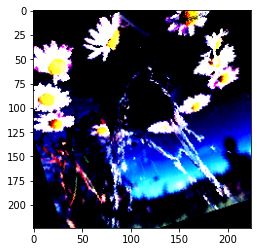

In [ ]:
show_example(*dataset[2])

In [ ]:
print(len(dataset))

4323


### Now creating the custom model

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Defining model

In [ ]:
class Simple_Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model=Simple_Model()
model

Simple_Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featu

In [ ]:
if torch.cuda.is_available():
       device= torch.device('cuda')
else:
        device=torch.device('cpu')

In [ ]:
val_size=500
train_size=len(dataset)-val_size
train_ds,val_main=random_split(dataset,[train_size,val_size])

val_ds,test_ds=random_split(val_main,[300,200])
print(train_size,val_size,test_ds)

3823 500 <torch.utils.data.dataset.Subset object at 0x7f3d80ef3c10>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  tulip (4)


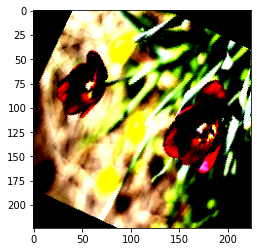

In [ ]:
show_example(*test_ds[1])

### setting up batch size

In [ ]:
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4)
test_dl=DataLoader(test_ds,batch_size,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for images,label in train_dl:
    print(images.shape)
    out=model(images)
    print("output shape ",out.shape)
    print(out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 3, 224, 224])
output shape  torch.Size([32, 5])
tensor([-0.0292, -0.0185, -0.0441, -0.0257, -0.0159], grad_fn=<SelectBackward>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]#passing batches to validation step calculating accuracies..
    return model.validation_epoch_end(outputs)#combining losses and accuracies of one epoch

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)#for each batch calculate the loss 
            train_losses.append(loss)
            loss.backward()#compute the gradients
            optimizer.step()
            optimizer.zero_grad()#reset the gradients to zero
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
model = to_device(Simple_Model(), device)
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.17982955276966095, 'val_loss': 1.611558198928833}

### Setting Hyper-parameters

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01

### training the model

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 6764.3286, val_loss: 1.5903, val_acc: 0.2764
Epoch [1], train_loss: 1.5236, val_loss: 1.4672, val_acc: 0.3045
Epoch [2], train_loss: 1.4870, val_loss: 1.4477, val_acc: 0.3693
Epoch [3], train_loss: 1.4627, val_loss: 1.4382, val_acc: 0.3543
Epoch [4], train_loss: 1.4532, val_loss: 1.4352, val_acc: 0.3807
Epoch [5], train_loss: 1.4545, val_loss: 1.5176, val_acc: 0.3003
Epoch [6], train_loss: 1.4641, val_loss: 1.3661, val_acc: 0.3724
Epoch [7], train_loss: 1.4314, val_loss: 1.3884, val_acc: 0.3818
Epoch [8], train_loss: 1.4316, val_loss: 1.4480, val_acc: 0.3398
Epoch [9], train_loss: 1.4302, val_loss: 1.4637, val_acc: 0.3401


#Transfer Learning using ResNets

###Importing ResNet into our notebook

In [ ]:
resnet = torchvision.models.resnet34(pretrained=True)

### Getting to know the structure of ResNet

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
ftr = resnet.fc.in_features
resnet.fc = nn.Linear(ftr, 5)

resnet = resnet.cuda()

### setting up the optimizer

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

In [ ]:
total_step = len(train_dl)
Loss = []
Acc = []
Val_Loss = []
Val_Acc = []


for epoch in range(5):
  acc = 0
  val_acc = 0
  for i, (images, labels) in enumerate(train_dl):
    resnet.train()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet(images)
    loss = criterion(outputs, labels)

     # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  acc = acc/len(train_ds) * 100
    
  for i, (images, labels) in enumerate(val_dl):
    resnet.eval()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet(images)
    val_loss = criterion(outputs, labels)
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    val_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  val_acc = val_acc/len(val_ds) * 100
    
  print("Epoch {} =>  loss : {loss:.2f};   Accuracy : {acc:.2f}%;   Val_loss : {val_loss:.2f};   Val_Accuracy : {val_acc:.2f}%".format(epoch+1, loss=loss.item(), acc=acc, val_loss=val_loss.item(), val_acc=val_acc))
  Loss.append(loss)
  Acc.append(acc)

  Val_Loss.append(val_loss)
  Val_Acc.append(val_acc)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 =>  loss : 0.22;   Accuracy : 85.27%;   Val_loss : 0.50;   Val_Accuracy : 85.67%
Epoch 2 =>  loss : 0.22;   Accuracy : 87.10%;   Val_loss : 0.28;   Val_Accuracy : 89.00%
Epoch 3 =>  loss : 0.66;   Accuracy : 87.31%;   Val_loss : 0.23;   Val_Accuracy : 87.67%
Epoch 4 =>  loss : 0.15;   Accuracy : 88.62%;   Val_loss : 0.41;   Val_Accuracy : 89.00%
Epoch 5 =>  loss : 0.06;   Accuracy : 87.76%;   Val_loss : 0.17;   Val_Accuracy : 88.67%


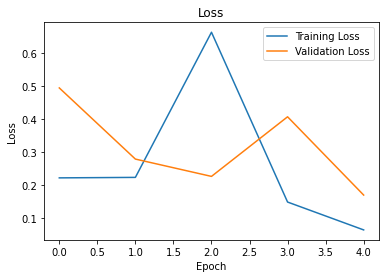

In [ ]:
plt.plot(range(5),Loss)
plt.plot(range(5),Val_Loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

The accuracy has improved a lot as soon as we used transfer learning approach.